In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from autode.autode import ODE

import time

from sklearn.model_selection import KFold

np.random.seed(123)

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/Xylan_full_passage.csv")
gLV_data.head()

,Treatments,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
0,COMM10<AC_passage1.0,0.0,0.002365,0.000840,0.000829,0.001313,0.000970,0.000679,0.000812,0.000646,0.001287,0.000257
1,COMM10<AC_passage1.0,24.0,0.014662,0.101607,0.000760,0.384594,0.277335,0.056530,0.001876,0.002736,0.089326,0.197074
2,COMM10<AC_passage2.0,0.0,0.000733,0.005080,0.000038,0.019230,0.013867,0.002826,0.000094,0.000137,0.004466,0.009854
3,COMM10<AC_passage2.0,24.0,0.011976,0.211938,0.000000,0.465521,0.168343,0.004875,0.003701,0.000000,0.023428,0.174718
4,COMM10<AC_passage3.0,0.0,0.000599,0.010597,0.000000,0.023276,0.008417,0.000244,0.000185,0.000000,0.001171,0.008736


In [3]:
# get species names
species = list(gLV_data.columns.values[2:])

# Define function to make predictions on test data

In [4]:
# Define function to make predictions on test data

def test(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)
    
    # save true values and predictions
    true = []
    pred = []
    stdv = []
    spcs = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])
        
        # predict end-point measured values
        output, output_stdv, _ = model.predict(x_test, tspan)
        true.append(output_true[-1])
        pred.append(output[-1, :len(species)])
        stdv.append(output_stdv[-1, :len(species)])
        spcs.append(species)
        
    return np.concatenate(true), np.concatenate(pred), np.concatenate(stdv), np.concatenate(spcs)

# Initialize model parameters

In [5]:
# define initial parameter guess
dim = len(species)
n_params = dim + dim**2 
params = np.zeros(n_params)
# set growth rates positive
params[:dim] = 0.3

params[dim:] = 0.0
k = dim 
# set Aii terms negative to stabilize initial guess
for i in range(dim):
    for j in range(dim):
        if i == j:
            params[k] = -1.0
        k += 1
        
# set prior to be same as initial parameter guess
prior = np.copy(params)

# Define model

In [6]:
# using gLV model 
def system(t, s, params, ctrl_params): 
    
    # determine dimension
    ns = len(s)
    
    # map to hidden dimension
    a = params[:ns]
    A = np.reshape(params[ns:ns+ns**2], [ns,ns])

    # rate of change of species 
    dsdt = s * (A@s + a) 

    return dsdt

# K-fold cross-validation

In [7]:
# split dataframes according to treatment name 
mono_df = pd.concat([df for name, df in gLV_data.groupby("Treatments") if "Mono" in name])
dfs = [df for name, df in gLV_data.groupby("Treatments") if "Mono" not in name]

# set up Kfold object 
kf = KFold(n_splits = 15, shuffle=True, random_state=123)

In [8]:
# save true values, test predictions and uncertainty to a dataframe
kfold_df = pd.DataFrame()

for i, (train_ind, test_ind) in enumerate(kf.split(dfs)):
    
    # pull train and test data
    train_data = pd.concat([dfs[ind] for ind in train_ind])
    train_data = pd.concat([mono_df, train_data])

    # test data does not include mono culture
    test_data  = pd.concat([dfs[ind] for ind in test_ind])

    # instantiate gLV fit 
    model = ODE(system = system, 
                df=train_data, 
                sys_vars = species, 
                params = params, 
                prior = prior, 
                alpha_0=1e-5) 

    # fit to data 
    t0 = time.time()
    model.fit(evidence_tol=1e-3, patience=1, max_fails=2)
    print("Elapsed time {:.2f}s".format(time.time()-t0))

    # test model 
    true, pred, stdv, spcs = test(model, test_data)

    # save results
    fold_df = pd.DataFrame()
    fold_df['True'] = true
    fold_df['Pred'] = pred
    fold_df['Stdv'] = stdv
    fold_df['Spcs'] = spcs
    kfold_df = pd.concat((kfold_df, fold_df))

Updating precision...
Total samples: 92, Updated regularization: 1.00e-05
Total weighted fitting error: 3.508
Total weighted fitting error: 2.754
Total weighted fitting error: 2.310
Total weighted fitting error: 2.047
Total weighted fitting error: 1.979
Total weighted fitting error: 1.870
Total weighted fitting error: 1.720
Total weighted fitting error: 1.717
Total weighted fitting error: 1.685
Total weighted fitting error: 1.628
Total weighted fitting error: 1.612
Total weighted fitting error: 1.503
Total weighted fitting error: 1.487
Total weighted fitting error: 1.474
Total weighted fitting error: 1.455
Total weighted fitting error: 1.419
Total weighted fitting error: 1.411
Total weighted fitting error: 1.348
Total weighted fitting error: 1.345
Total weighted fitting error: 1.339
Total weighted fitting error: 1.281
Total weighted fitting error: 1.276
Total weighted fitting error: 1.266
Total weighted fitting error: 1.249
Total weighted fitting error: 1.235
Total weighted fitting err

Total weighted fitting error: 1.238
Total weighted fitting error: 1.237
Total weighted fitting error: 1.237
Total weighted fitting error: 1.222
Total weighted fitting error: 1.222
Total weighted fitting error: 1.216
Total weighted fitting error: 1.216
Total weighted fitting error: 1.203
Total weighted fitting error: 1.203
Total weighted fitting error: 1.202
Total weighted fitting error: 1.199
Total weighted fitting error: 1.199
Total weighted fitting error: 1.192
Total weighted fitting error: 1.192
Total weighted fitting error: 1.182
Total weighted fitting error: 1.182
Total weighted fitting error: 1.181
Total weighted fitting error: 1.179
Total weighted fitting error: 1.179
Total weighted fitting error: 1.178
Total weighted fitting error: 1.177
Total weighted fitting error: 1.177
Total weighted fitting error: 1.174
Total weighted fitting error: 1.174
Total weighted fitting error: 1.171
Total weighted fitting error: 1.171
Total weighted fitting error: 1.170
Total weighted fitting error

Total weighted fitting error: 1.209
Total weighted fitting error: 1.209
Total weighted fitting error: 1.208
Total weighted fitting error: 1.204
Total weighted fitting error: 1.204
Total weighted fitting error: 1.194
Total weighted fitting error: 1.193
Total weighted fitting error: 1.193
Total weighted fitting error: 1.192
Total weighted fitting error: 1.191
Total weighted fitting error: 1.191
Total weighted fitting error: 1.184
Total weighted fitting error: 1.184
Total weighted fitting error: 1.183
Total weighted fitting error: 1.181
Total weighted fitting error: 1.181
Total weighted fitting error: 1.179
Total weighted fitting error: 1.179
Total weighted fitting error: 1.175
Total weighted fitting error: 1.174
Total weighted fitting error: 1.174
Total weighted fitting error: 1.173
Total weighted fitting error: 1.172
Total weighted fitting error: 1.171
Total weighted fitting error: 1.171
Total weighted fitting error: 1.170
Total weighted fitting error: 1.170
Total weighted fitting error

Total weighted fitting error: 464.100
Total weighted fitting error: 464.099
Total weighted fitting error: 464.094
Total weighted fitting error: 464.093
Total weighted fitting error: 464.088
Total weighted fitting error: 464.086
Total weighted fitting error: 464.086
Total weighted fitting error: 464.078
Total weighted fitting error: 464.067
Total weighted fitting error: 464.066
Total weighted fitting error: 464.065
Total weighted fitting error: 464.065
Total weighted fitting error: 464.057
Total weighted fitting error: 464.044
Total weighted fitting error: 464.043
Total weighted fitting error: 464.042
Total weighted fitting error: 464.041
Total weighted fitting error: 464.041
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 464.04053038526615
       x: [ 4.426e-01  4.193e-01 ... -1.119e-01 -1.345e+00]
     nit: 123
     jac: [ 4.422e-01  2.968e-02 ...  3.116e-02  2.610e-02]
    nfev: 182
    njev: 182
    nhev: 123
Evidence 2414.061
Updating precision

Total weighted fitting error: 489.287
Total weighted fitting error: 489.269
Total weighted fitting error: 489.267
Total weighted fitting error: 489.215
Total weighted fitting error: 489.215
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 489.2149033110884
       x: [ 4.512e-01  3.777e-01 ... -1.096e-01 -1.016e+00]
     nit: 16
     jac: [ 7.775e-01 -4.364e-01 ... -2.782e-02 -7.039e-02]
    nfev: 22
    njev: 22
    nhev: 16
Evidence 2464.554
Pass count  1
Elapsed time 266.42s
Updating precision...
Total samples: 98, Updated regularization: 1.00e-05
Total weighted fitting error: 3.501
Total weighted fitting error: 2.782
Total weighted fitting error: 2.366
Total weighted fitting error: 2.103
Total weighted fitting error: 1.960
Total weighted fitting error: 1.949
Total weighted fitting error: 1.853
Total weighted fitting error: 1.803
Total weighted fitting error: 1.794
Total weighted fitting error: 1.716
Total weighted fitting error: 1.643
Total weight

Total weighted fitting error: 18.229
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 18.22927223008402
       x: [ 4.759e-01  4.546e-01 ... -2.221e-01 -1.310e+00]
     nit: 10
     jac: [-1.511e-01  8.300e-02 ... -1.579e-02 -5.719e-02]
    nfev: 21
    njev: 21
    nhev: 10
Evidence 984.180
Updating precision...
Total samples: 98, Updated regularization: 9.51e-05
Total weighted fitting error: 128.696
Total weighted fitting error: 128.674
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 128.6737535908355
       x: [ 4.778e-01  4.583e-01 ... -2.221e-01 -1.311e+00]
     nit: 2
     jac: [-4.400e+00  1.881e+00 ... -1.393e-01 -2.917e-01]
    nfev: 80
    njev: 70
    nhev: 3
Evidence 1860.707
Updating precision...
Total samples: 98, Updated regularization: 7.96e-05
Total weighted fitting error: 195.456
Total weighted fitting error: 193.827
Total weighted fitting error: 191.889
 message

/home/jaron/Documents/BAMF/autode/autode.py:471: RuntimeWarning: invalid value encountered in log
  np.sum(np.log(np.linalg.eigvalsh(self.A)))/2. - \
/home/jaron/Documents/BAMF/autode/autode.py:472: RuntimeWarning: invalid value encountered in log
  self.NLP + self.N*np.sum(np.log(np.linalg.eigvalsh(self.Beta)))/2.


Evidence nan
Updating precision...
Total samples: 98, Updated regularization: 8.62e-05
Total weighted fitting error: 455.004
Total weighted fitting error: 454.042
Total weighted fitting error: 452.757
Total weighted fitting error: 450.494
Total weighted fitting error: 448.661
Total weighted fitting error: 448.553
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 448.5527440567323
       x: [ 4.664e-01  4.607e-01 ... -2.149e-01 -1.317e+00]
     nit: 6
     jac: [ 6.515e+00  4.358e+00 ... -4.995e+00 -7.579e-01]
    nfev: 12
    njev: 12
    nhev: 6
Evidence 2285.943
Updating precision...
Total samples: 98, Updated regularization: 6.74e-05
Total weighted fitting error: 475.325
Total weighted fitting error: 474.579
Total weighted fitting error: 474.264
Total weighted fitting error: 474.135
Total weighted fitting error: 474.080
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 474.08000656047517
       x: [ 4.636e-01  4.6

Evidence 2483.711
Updating precision...
Total samples: 100, Updated regularization: 9.98e-04
Total weighted fitting error: 491.935
Total weighted fitting error: 491.467
Total weighted fitting error: 491.466
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 491.4661047554406
       x: [ 3.607e-01  4.360e-01 ... -7.792e-01 -1.923e+00]
     nit: 3
     jac: [ 4.519e-01 -2.748e+01 ... -1.464e-01  1.399e-01]
    nfev: 4
    njev: 4
    nhev: 3
Evidence 2486.443
Updating precision...
Total samples: 100, Updated regularization: 1.01e-03
Total weighted fitting error: 492.885
Total weighted fitting error: 492.882
Total weighted fitting error: 492.385
Total weighted fitting error: 492.359
Total weighted fitting error: 492.151
Total weighted fitting error: 492.151
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 492.15067799991084
       x: [ 3.568e-01  4.390e-01 ... -8.047e-01 -1.919e+00]
     nit: 6
     jac: [-2.695e-02 -2.

Evidence 2361.060
Updating precision...
Total samples: 98, Updated regularization: 3.26e-04
Total weighted fitting error: 481.712
Total weighted fitting error: 481.552
Total weighted fitting error: 481.272
Total weighted fitting error: 480.739
Total weighted fitting error: 479.820
Total weighted fitting error: 479.732
Total weighted fitting error: 479.013
Total weighted fitting error: 479.010
Total weighted fitting error: 478.988
Total weighted fitting error: 478.782
Total weighted fitting error: 478.724
Total weighted fitting error: 478.617
Total weighted fitting error: 478.440
Total weighted fitting error: 478.439
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 478.4387221202369
       x: [ 4.667e-01  3.790e-01 ...  1.483e-01 -1.933e+00]
     nit: 14
     jac: [-4.265e+00 -7.466e+00 ...  2.414e-02  1.200e-01]
    nfev: 19
    njev: 19
    nhev: 14
Evidence 2364.025
Updating precision...
Total samples: 98, Updated regularization: 3.41e-04
Total wei

Total weighted fitting error: 110.895
Total weighted fitting error: 110.866
Total weighted fitting error: 110.814
Total weighted fitting error: 108.750
Total weighted fitting error: 108.656
Total weighted fitting error: 108.482
Total weighted fitting error: 108.196
Total weighted fitting error: 106.962
Total weighted fitting error: 106.875
Total weighted fitting error: 106.720
Total weighted fitting error: 105.798
Total weighted fitting error: 105.715
Total weighted fitting error: 105.377
Total weighted fitting error: 105.341
Total weighted fitting error: 105.341
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 105.34140753376289
       x: [ 5.211e-01  3.658e-01 ... -3.008e-01 -1.527e+00]
     nit: 30
     jac: [-8.407e-01  1.433e+00 ...  2.272e-01  3.474e-01]
    nfev: 50
    njev: 50
    nhev: 30
Evidence 1773.409
Updating precision...
Total samples: 96, Updated regularization: 1.42e-03
Total weighted fitting error: 280.542
Total weighted fitting e

/home/jaron/Documents/BAMF/autode/autode.py:471: RuntimeWarning: invalid value encountered in log
  np.sum(np.log(np.linalg.eigvalsh(self.A)))/2. - \
/home/jaron/Documents/BAMF/autode/autode.py:472: RuntimeWarning: invalid value encountered in log
  self.NLP + self.N*np.sum(np.log(np.linalg.eigvalsh(self.Beta)))/2.


Evidence nan
Updating precision...
Total samples: 96, Updated regularization: 2.03e-04
Total weighted fitting error: 481.196
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 481.19587830285843
       x: [ 5.256e-01  3.703e-01 ... -3.051e-01 -1.526e+00]
     nit: 1
     jac: [-1.502e+02 -9.149e+01 ... -6.567e-01 -9.555e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 2225.001
Updating precision...
Total samples: 96, Updated regularization: 1.68e-04
Total weighted fitting error: 447.190
Total weighted fitting error: 446.133
Total weighted fitting error: 446.133
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 446.13337361305435
       x: [ 5.262e-01  3.710e-01 ... -3.051e-01 -1.526e+00]
     nit: 3
     jac: [-1.516e+02 -3.374e+01 ...  2.192e+00 -2.920e+00]
    nfev: 10
    njev: 10
    nhev: 3
Evidence 2215.309
Fail count  1
Updating precision...
Total samples: 96, Updated regularization: 1.69e-04
Total weighted fi

Evidence 2412.162
Updating precision...
Total samples: 99, Updated regularization: 2.20e-04
Total weighted fitting error: 490.125
Total weighted fitting error: 490.056
Total weighted fitting error: 489.931
Total weighted fitting error: 488.802
Total weighted fitting error: 488.791
Total weighted fitting error: 488.691
Total weighted fitting error: 488.559
Total weighted fitting error: 488.326
Total weighted fitting error: 488.318
Total weighted fitting error: 486.912
Total weighted fitting error: 486.902
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 486.9022270556909
       x: [ 4.674e-01  4.408e-01 ... -1.741e-01 -1.395e+00]
     nit: 11
     jac: [ 6.608e-01  1.009e+01 ... -1.495e-01  2.250e-01]
    nfev: 17
    njev: 17
    nhev: 11
Evidence 2418.775
Updating precision...
Total samples: 99, Updated regularization: 2.25e-04
Total weighted fitting error: 490.893
Total weighted fitting error: 490.198
Total weighted fitting error: 489.946
Total wei

Total weighted fitting error: 490.949
Total weighted fitting error: 490.722
Total weighted fitting error: 490.715
Total weighted fitting error: 490.702
Total weighted fitting error: 490.683
Total weighted fitting error: 490.653
Total weighted fitting error: 490.597
Total weighted fitting error: 490.595
Total weighted fitting error: 490.530
Total weighted fitting error: 490.529
Total weighted fitting error: 490.430
Total weighted fitting error: 490.430
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 490.43000139558336
       x: [ 4.568e-01  4.363e-01 ... -1.388e-01 -1.265e+00]
     nit: 13
     jac: [ 9.532e-01  2.387e+00 ... -1.301e-02 -2.126e-02]
    nfev: 19
    njev: 19
    nhev: 13
Evidence 2477.348
Updating precision...
Total samples: 99, Updated regularization: 2.70e-04
Total weighted fitting error: 491.443
Total weighted fitting error: 491.409
Total weighted fitting error: 491.127
Total weighted fitting error: 491.091
Total weighted fitting e

Total weighted fitting error: 14.052
Total weighted fitting error: 14.051
Total weighted fitting error: 14.050
Total weighted fitting error: 14.048
Total weighted fitting error: 14.045
Total weighted fitting error: 14.040
Total weighted fitting error: 14.040
Total weighted fitting error: 14.037
Total weighted fitting error: 14.031
Total weighted fitting error: 13.992
Total weighted fitting error: 13.990
Total weighted fitting error: 13.987
Total weighted fitting error: 13.983
Total weighted fitting error: 13.983
Total weighted fitting error: 13.978
Total weighted fitting error: 13.968
Total weighted fitting error: 13.955
Total weighted fitting error: 13.955
Total weighted fitting error: 13.953
Total weighted fitting error: 13.952
Total weighted fitting error: 13.952
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 13.951534415963398
       x: [ 3.661e-01  4.046e-01 ... -1.380e+00 -1.665e+00]
     nit: 43
     jac: [ 5.363e-02  9.951e-02 ... -2.649e-0

Total weighted fitting error: 0.928
Total weighted fitting error: 0.919
Total weighted fitting error: 0.919
Total weighted fitting error: 0.918
Total weighted fitting error: 0.918
Total weighted fitting error: 0.916
Total weighted fitting error: 0.915
Total weighted fitting error: 0.915
Total weighted fitting error: 0.911
Total weighted fitting error: 0.910
Total weighted fitting error: 0.909
Total weighted fitting error: 0.907
Total weighted fitting error: 0.907
Total weighted fitting error: 0.905
Total weighted fitting error: 0.905
Total weighted fitting error: 0.904
Total weighted fitting error: 0.904
Total weighted fitting error: 0.903
Total weighted fitting error: 0.902
Total weighted fitting error: 0.902
Total weighted fitting error: 0.901
Total weighted fitting error: 0.901
Total weighted fitting error: 0.900
Total weighted fitting error: 0.899
Total weighted fitting error: 0.899
Total weighted fitting error: 0.898
Total weighted fitting error: 0.898
Total weighted fitting error

Total weighted fitting error: 3.570
Total weighted fitting error: 2.885
Total weighted fitting error: 2.475
Total weighted fitting error: 2.449
Total weighted fitting error: 2.244
Total weighted fitting error: 1.989
Total weighted fitting error: 1.980
Total weighted fitting error: 1.895
Total weighted fitting error: 1.795
Total weighted fitting error: 1.737
Total weighted fitting error: 1.730
Total weighted fitting error: 1.674
Total weighted fitting error: 1.598
Total weighted fitting error: 1.596
Total weighted fitting error: 1.571
Total weighted fitting error: 1.558
Total weighted fitting error: 1.533
Total weighted fitting error: 1.509
Total weighted fitting error: 1.503
Total weighted fitting error: 1.501
Total weighted fitting error: 1.486
Total weighted fitting error: 1.459
Total weighted fitting error: 1.457
Total weighted fitting error: 1.409
Total weighted fitting error: 1.407
Total weighted fitting error: 1.390
Total weighted fitting error: 1.383
Total weighted fitting error

Evidence 1912.327
Updating precision...
Total samples: 100, Updated regularization: 7.03e-05
Total weighted fitting error: 322.280
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 322.279539119238
       x: [ 4.200e-01  4.852e-01 ... -2.633e-01 -1.349e+00]
     nit: 1
     jac: [-2.624e+01 -1.186e+02 ... -2.561e+00  1.253e+00]
    nfev: 46
    njev: 39
    nhev: 1
Evidence 2316.336
Updating precision...
Total samples: 100, Updated regularization: 6.52e-05
Total weighted fitting error: 436.370
Total weighted fitting error: 436.357
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 436.35714019107064
       x: [ 4.198e-01  4.868e-01 ... -2.632e-01 -1.349e+00]
     nit: 2
     jac: [ 6.333e+01 -5.405e+01 ... -7.264e+00  1.154e+00]
    nfev: 3
    njev: 3
    nhev: 2
Evidence 2386.505
Updating precision...
Total samples: 100, Updated regularization: 5.94e-05
Total weighted fitting error: 483.891
 message: Optimization te

Total weighted fitting error: 11.924
Total weighted fitting error: 11.918
Total weighted fitting error: 11.917
Total weighted fitting error: 11.913
Total weighted fitting error: 11.913
Total weighted fitting error: 11.899
Total weighted fitting error: 11.899
Total weighted fitting error: 11.899
Total weighted fitting error: 11.899
Total weighted fitting error: 11.890
Total weighted fitting error: 11.890
Total weighted fitting error: 11.890
Total weighted fitting error: 11.887
Total weighted fitting error: 11.887
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 11.887384619684989
       x: [ 3.862e-01  3.775e-01 ... -2.495e-01 -1.162e+00]
     nit: 50
     jac: [ 1.102e-01  2.427e-02 ...  3.406e-03 -3.053e-03]
    nfev: 78
    njev: 78
    nhev: 50
Evidence 912.492
Updating precision...
Total samples: 97, Updated regularization: 3.44e-04
Total weighted fitting error: 95.651
Total weighted fitting error: 95.616
Total weighted fitting error: 95.553
Tota

Total samples: 97, Updated regularization: 3.36e-04
Total weighted fitting error: 476.432
Total weighted fitting error: 476.178
Total weighted fitting error: 475.768
Total weighted fitting error: 475.283
Total weighted fitting error: 475.263
Total weighted fitting error: 475.084
Total weighted fitting error: 474.837
Total weighted fitting error: 474.833
Total weighted fitting error: 474.826
Total weighted fitting error: 474.822
Total weighted fitting error: 474.781
Total weighted fitting error: 474.719
Total weighted fitting error: 474.718
Total weighted fitting error: 474.687
Total weighted fitting error: 474.687
Total weighted fitting error: 474.679
Total weighted fitting error: 474.667
Total weighted fitting error: 474.667
Total weighted fitting error: 474.667
Total weighted fitting error: 474.662
Total weighted fitting error: 474.662
Total weighted fitting error: 474.661
Total weighted fitting error: 474.660
Total weighted fitting error: 474.659
Total weighted fitting error: 474.65

Total weighted fitting error: 1.025
Total weighted fitting error: 1.025
Total weighted fitting error: 1.022
Total weighted fitting error: 1.021
Total weighted fitting error: 1.018
Total weighted fitting error: 1.018
Total weighted fitting error: 1.015
Total weighted fitting error: 1.015
Total weighted fitting error: 1.014
Total weighted fitting error: 1.013
Total weighted fitting error: 1.012
Total weighted fitting error: 1.012
Total weighted fitting error: 1.010
Total weighted fitting error: 1.009
Total weighted fitting error: 1.007
Total weighted fitting error: 1.007
Total weighted fitting error: 1.007
Total weighted fitting error: 1.004
Total weighted fitting error: 1.004
Total weighted fitting error: 1.004
Total weighted fitting error: 1.004
Total weighted fitting error: 1.003
Total weighted fitting error: 1.003
Total weighted fitting error: 1.001
Total weighted fitting error: 1.001
Total weighted fitting error: 1.001
Total weighted fitting error: 1.000
Total weighted fitting error

Total weighted fitting error: 1.123
Total weighted fitting error: 1.122
Total weighted fitting error: 1.122
Total weighted fitting error: 1.122
Total weighted fitting error: 1.122
Total weighted fitting error: 1.122
Total weighted fitting error: 1.121
Total weighted fitting error: 1.121
Total weighted fitting error: 1.120
Total weighted fitting error: 1.119
Total weighted fitting error: 1.119
Total weighted fitting error: 1.119
Total weighted fitting error: 1.119
Total weighted fitting error: 1.116
Total weighted fitting error: 1.116
Total weighted fitting error: 1.116
Total weighted fitting error: 1.116
Total weighted fitting error: 1.116
Total weighted fitting error: 1.116
Total weighted fitting error: 1.115
Total weighted fitting error: 1.115
Total weighted fitting error: 1.115
Total weighted fitting error: 1.115
Total weighted fitting error: 1.113
Total weighted fitting error: 1.113
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.1134045381403

Evidence 2526.899
Pass count  1
Elapsed time 169.74s
Updating precision...
Total samples: 97, Updated regularization: 1.00e-05
Total weighted fitting error: 3.550
Total weighted fitting error: 2.816
Total weighted fitting error: 2.394
Total weighted fitting error: 2.114
Total weighted fitting error: 2.044
Total weighted fitting error: 1.928
Total weighted fitting error: 1.752
Total weighted fitting error: 1.723
Total weighted fitting error: 1.680
Total weighted fitting error: 1.626
Total weighted fitting error: 1.620
Total weighted fitting error: 1.568
Total weighted fitting error: 1.558
Total weighted fitting error: 1.539
Total weighted fitting error: 1.506
Total weighted fitting error: 1.505
Total weighted fitting error: 1.463
Total weighted fitting error: 1.462
Total weighted fitting error: 1.432
Total weighted fitting error: 1.425
Total weighted fitting error: 1.414
Total weighted fitting error: 1.414
Total weighted fitting error: 1.402
Total weighted fitting error: 1.380
Total wei

Total weighted fitting error: 339.491
Total weighted fitting error: 339.487
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 339.48696925726813
       x: [ 3.142e-01  4.385e-01 ... -2.206e-01 -1.077e+00]
     nit: 7
     jac: [ 8.115e+00 -1.025e+01 ...  1.718e-03  1.884e+00]
    nfev: 8
    njev: 8
    nhev: 7
Evidence 2294.135
Updating precision...
Total samples: 97, Updated regularization: 2.51e-04
Total weighted fitting error: 451.891
Total weighted fitting error: 451.509
Total weighted fitting error: 450.789
Total weighted fitting error: 449.570
Total weighted fitting error: 448.392
Total weighted fitting error: 448.219
Total weighted fitting error: 446.800
Total weighted fitting error: 446.781
Total weighted fitting error: 446.095
Total weighted fitting error: 446.094
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 446.0944428683839
       x: [ 3.093e-01  4.243e-01 ... -1.783e-01 -1.069e+00]
     nit: 10
    

In [9]:
kfold_df.to_csv("kfold/gLV_kfold_fiber.csv", index=False)

In [10]:
kfold_df

,True,Pred,Stdv,Spcs
0,0.010416,0.058448,0.035804,S1
1,0.116792,0.019805,0.061561,S2
2,0.002013,0.000688,0.048476,S3
3,0.203811,0.018577,0.064310,S4
4,0.142743,0.251732,0.070044,S5
...,...,...,...,...
55,0.000000,0.000000,0.059006,S6
56,0.017377,0.000011,0.037096,S7
57,0.053563,0.000063,0.034417,S8
58,0.008348,0.124363,0.079776,S9


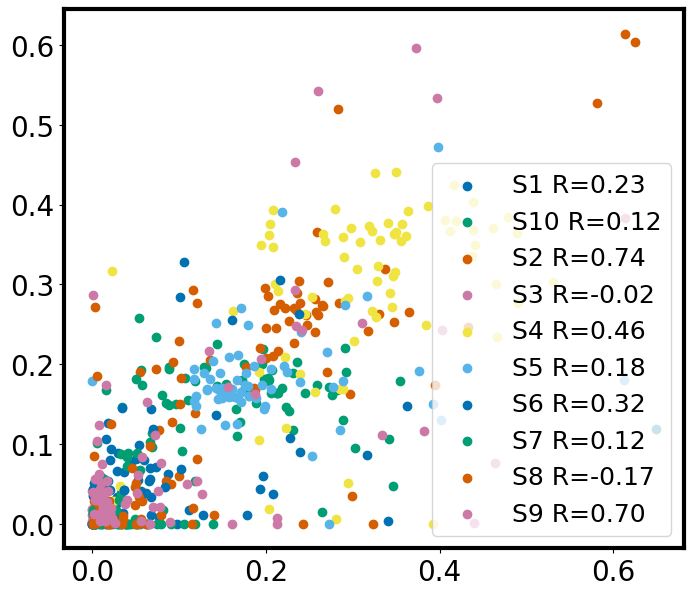

In [11]:
true = kfold_df['True'].values
pred = kfold_df['Pred'].values
stdv = kfold_df['Stdv'].values
spcs = kfold_df['Spcs'].values

for i,sp in enumerate(np.unique(spcs)):
    sp_inds = spcs == sp
    inds_pos = true[sp_inds] > 0
    
    true_vals = np.nan_to_num(true[sp_inds][inds_pos])
    pred_vals = np.nan_to_num(pred[sp_inds][inds_pos])
    
    R = linregress(true_vals, pred_vals).rvalue
    plt.scatter(true_vals, pred_vals, c=f"C{i}", label=sp + " R={:.2f}".format(R))
plt.legend(loc="lower right")
plt.savefig("kfold/gLV_kfold_fiber.pdf")
plt.show()